In [2]:
import pandas as pd
import numpy as np
import re
from string import punctuation
import nltk
from gensim import models, corpora
from tqdm import tqdm
import matplotlib.pyplot as plt

In [1]:
nltk.download('wordnet')
nltk.download('stopwords')

# Processing texts

In [3]:
split_line = '-------------------'

def get_abstract(text):
    parts = text.split('Abstract:')
    assert len(parts) == 2
    
    return parts[1].strip()

def load_texts(path='HW1.txt'):
    texts = []
    with open(path, 'r') as f:
        text = []
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line == split_line:
                texts.append(get_abstract("\n".join(text)))
                text = []
            elif len(line) > 0:
                text.append(line)
                
        if len(text) > 0:
            texts.append(get_abstract("\n".join(text)))
            
    return texts


def not_number(word):
    return len(re.split(r'.*[0-9].*', word)) == 1


def remove_empty(words):
    without_empty = []
    for word in words:
        if len(word) > 4 and not_number(word):
            without_empty.append(word)
            
    return without_empty


def word_split(texts):
    regex = f'[{punctuation}\n][ \t]*|[ \t]+'
    texts_word = []
    for text in texts:
        texts_word.append(remove_empty(re.split(regex, text.lower().strip())))
        
    return texts_word

In [4]:
def lemmatize(texts):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lem_texts = []
    
    for text in texts:
        lem_texts.append([lemmatizer.lemmatize(word) for word in text])
        
    return lem_texts

def remove_stopwords(texts):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    wout_stop_texts = []
    for text in texts:
        wout_stop_texts.append([word for word in text if word not in stopwords])
        
    return wout_stop_texts

def clean_texts(texts):
    splitted = word_split(texts)
    lemmatized = lemmatize(splitted)
    
    return remove_stopwords(lemmatized)

### Cleaning data

In [5]:
data = load_texts()
data = clean_texts(data)

In [6]:
all_words = []
for words in data:
    all_words += words
    
unique_words = list(set(all_words))

### Preparing tfidf

In [7]:
dictionary = corpora.Dictionary(data)
corpus = [dictionary.doc2bow(text) for text in data]
tfidf_model = models.TfidfModel(corpus)  
tfidf = tfidf_model[corpus]

# Modeling

### Model with best results is LDA
First let's try with 4 topics

In [8]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=4)
topics = lda.print_topics(num_words=2)
topics

[(0, '0.003*"protein" + 0.003*"mutant"'),
 (1, '0.003*"expression" + 0.003*"protein"'),
 (2, '0.006*"centrosome" + 0.003*"spindle"'),
 (3, '0.004*"protein" + 0.004*"pathway"')]

First let's try with 3 topics

In [9]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=3)
topics = lda.print_topics(num_words=2)
topics

[(0, '0.003*"channel" + 0.003*"genome"'),
 (1, '0.002*"dauer" + 0.001*"peptide"'),
 (2, '0.003*"protein" + 0.003*"pathway"')]

First let's try with 2 topics

In [10]:
lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=2)
topics = lda.print_topics(num_words=2)
topics

[(0, '0.003*"cell" + 0.002*"vulval"'),
 (1, '0.003*"protein" + 0.003*"expression"')]

It seems that the best number of themes is 3
1. Something about life and health
2. Some common biology (chromosomes, etc)
3. Sport and food

### Let's find coherence

In [11]:
def get_coherence_LDA(n_topics):
    lda = models.LdaModel(tfidf, id2word=dictionary, num_topics=n_topics)
    stats = models.coherencemodel.CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    return stats.get_coherence()

def get_coherence_LSI(n_topics):
    lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=n_topics)
    stats = models.coherencemodel.CoherenceModel(model=lsi, corpus=corpus, coherence='u_mass')
    return stats.get_coherence()

In [12]:
n_topics = list(range(2, 10))
LDA_coherences = [get_coherence_LDA(topics) for topics in tqdm(n_topics)]

100%|██████████| 8/8 [01:31<00:00, 11.42s/it]


In [13]:
LSI_coherences = [get_coherence_LSI(topics) for topics in tqdm(n_topics)]

100%|██████████| 8/8 [00:41<00:00,  5.16s/it]


### LDA coherences

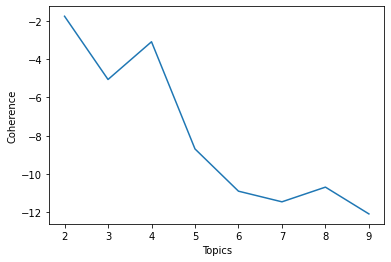

In [14]:
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.plot(n_topics, LDA_coherences);

### LSI coherences

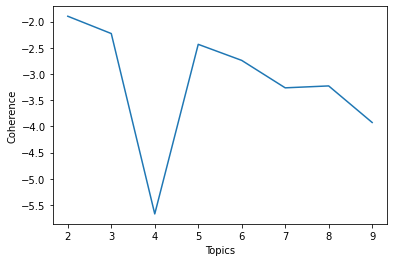

In [15]:
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.plot(n_topics, LSI_coherences);

Coherence results looks very strange, the first model prefers 4 topics, while second states that it is the worst choice.